
<img src="https://raw.githubusercontent.com/archivesunleashed/archivesunleashed.org/master/themes/hugo-material-docs/static/images/logo-square.png" height="100px" width="100px">


# Welcome

Welcome to the Archives Unleashed Cloud Jupyter Notebook. This demonstration takes the main derivatives from the Cloud and uses Python to analyze and produce information about your collection.

Please feel free to create an [issue](https://github.com/archivesunleashed/auk/issues) to let us know about any bugs you encountered or improvements you would like to see.

If you have Python experience, please feel free to change the provided code to suit your own needs.

We recommend that you use `File > Make a Copy` first before changing the code in the repository. That way, you can always return to the basic visualizations we have offered here. Of course, you can also just re-download the Jupyter Notebook file from your Archives Unleashed Cloud account.

### How Jupyter Notebooks Work:

If you have no previous experience with Jupyter Notebooks, the most important thing to understand is that that `<Shift> + <Enter/Return>` will run the Python code inside a cell and output it to below the cell.
    
The cells that cover the required inputs, marked "Setup", need to be run before the rest of the notebook will work. These cells will import all the libraries and set basic variables (e.g. where your derivative files are located) for the notebook. After that, everything else should be able to run on its own.

If you just want to see all results for your collection, use `Cell > Run All`.


# Setup

In [2]:
# Required imports from sys

from collections import Counter
import logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.draw.dispersion import dispersion_plot as dp
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Add the collection id of your Archive-It collection:
coll_id = ""
# Change the path to your derivatives files if they are not in the data directory.
auk_fp = "./data/"
auk_full_text = auk_fp + coll_id + "-fulltext.txt"
auk_gephi = auk_fp + coll_id + "-gephi.gexf"
auk_graphml = auk_fp + coll_id + "-gephi.graphml"
auk_domains = auk_fp + coll_id + "-fullurls.txt"
auk_filtered_text = auk_fp + coll_id + "-filtered_text.zip"

## User Configuration

The following cell sets out some user-generated variables. Take a look here: are there any domains you are not interested in? How many words would you like to be shown? Do you want to filter out 404 results? Do you want to sample the data? Read the choices below carefully.

In [3]:
# maximum number of words to show in output.
# Jupyter will create an output error if the number is too high.
TOP_COUNT = 30 

# Domain suffixes to check non-U.S. domains.
# so that (e.g.) www.google.co.uk will become "google"
STOP_DOMAINS = ["co", "org", "net", "edu"] # domain suffixes to remove

# minimum number of characters for a word to be included in a corpus
MINIMUM_WORD_LENGTH = 3 # eliminates "it", "I", "be" etc.

# list of substrings to filter a text line, if desired
LINE_FILTER = ['404 Not Found']

# The number of the last line of text to ingest
RESULTS_LIMIT = 2500

# If you want to start ingesting at a different line, you can increase this.
# If RESULTS_START is great than RESULTS_LIMIT you will get no results.
RESULTS_START = 0

# If you have a large file but want to sample the file more broadly, you
# can increase this value skip to every Nth line.
RESULTS_STEP = 5

# change if you want a different filename.
OUTPUT_FILENAME = "./filtered_text.txt" # filename if you want to output to another file.

# characters to show per text file in output. Larger numbers will results in more
# text showing in output
MAX_CHARACTERS = 75

# The years to include in the analysis. If empty, you will get all available years.
FILTERED_YEARS = [] # e.g. ['2015', '2016', '2019']

# The domains to include in the analysis. If empty, you will get all available domains.
FILTERED_DOMAINS = [] # e.g ["google", "apple", "facebook"]

# List of words not to include in a corpus for text analysis
STOP_WORDS = set(stopwords.words('english'))

## Archives Unleashed Cloud Python Library

The below cell now sets up the functions that drive the analysis throughout this notebook. If you don't run it, you won't be able to work with the data. 

In [53]:
def clean_domain(s):
    """Extracts the name from the domain (e.g. 'www.google.com' becomes 'google').
    
    :param: s: the domain name to clean
    :return: the relevant name
    -------
    
    """
    ret = ""
    dom = s.split(".")
    if len(dom) <3: # x.com is always x
        ret = dom[0]
    elif dom[-2] in STOP_DOMAINS: # www.x.co.uk should be x
        ret = dom[-3]
    else:
        ret = dom[1]
    return ret

def get_domains(split_method="full"):
    """Extracts the domains from a file by method..
    
    :param split_method: Either "full" "name" or "sub". "name" provides just the domain name, 
         "sub" produces the name with subdomains. "full" provides the entire name. 
    :return: a list of tuples containing (urlname, count)
    """
    ret = []
    with open(auk_domains) as fin:
        for line in fin:
            ret.append(line.strip('()\n').split(","))
    if split_method == 'name':
        scores = Counter()
        for url, count in ret:
            scores.update({clean_domain(url): int(count)})
        ret = scores
    elif split_method == 'sub':
        scores = Counter()
        splits = [(x[0].split('.'), int(x[1])) for x in ret]
        for url, count in splits:
            if len(url) < 3:
                scores.update({'.'.join(['www', url[0]]) : count})
            else:
                scores.update({ '.'.join([url[0], url[1]]) : count})
        ret = scores
    else:
        scores = Counter()
        for url, count in ret:
            scores.update({url: int(count)})
        ret = scores
    return ret

def get_text(by="all", minline=MINIMUM_WORD_LENGTH):
    """Get the text from the files (by domain or year if desired)
    
    :param by: "all", "domain" or "year" the output to return
    :param minline: the minimum size of a line to be included in the output
    :return: [(year/domain, text)] or [text] depending on by
    """
    text = []
    form = range(RESULTS_START, RESULTS_LIMIT, RESULTS_STEP)
    with open(auk_full_text) as fin:
        for num in range(RESULTS_LIMIT):
            if num in form:
                line = next(fin)
                split_line = str(line).split(",", 3)
                if (len(split_line[3]) >= MINIMUM_WORD_LENGTH and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):   
                    if by == "domain": 
                        text.append((clean_domain(split_line[1]), split_line[3]))
                    elif by == "year":
                        text.append((split_line[0][1:5], split_line[3]))
                    else:
                        text.append(split_line[3])
            else:
                next(fin)                   
    return text

def get_text_tokens (minlen=MINIMUM_WORD_LENGTH) :
    """Get the data and tokenize the text.
    
    :param minlen: the minimum word size to be included in the list of words.
    :return: a list of words included in the text file.
    """
    return [x.lower() for x in word_tokenize(' '.join(get_text())) if len(x) > minlen]

def get_tokens_domains(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by domain
    
    :param minlen: the minimum word size to be included in the list of words.
    :return: a list of tuples with (domain, Counter)"""
    return [(x[0], Counter([y for y in word_tokenize(x[1]) if len(y) > minlen])) for x in get_text("domain")]

def get_tokens_years(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by year.
    
    :para minlen: the minimum word size to be included in the list of words.
    :return: a list of tuples with (year, Counter)"""
    return [(x[0], Counter([y for y in word_tokenize(x[1]) if len(y) > minlen])) for x in get_text("year")]
    

def year(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get the tokens by year."""
    return get_tokens_years(minlen)

def domain(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get tokens by domain."""
    return get_tokens_domains(minlen)
 
def get_top_tokens(total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """Return the top tokens for the text."""
    return [(key, value) for key, value in Counter(get_text_tokens(minlen)).most_common(total)]

def get_top_tokens_by(fun, total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """ Get the top tokens by a function.
    
    Parameters
    ----------
    fun: A function that returns a list of (key, Counter([tokenized_list]))
    total: The number of top tokens to return for each key.
    minlen: The minimum word length.
    
    Returns
    -------
    ret: list of minlen tokens by fun.
    """
    
    sep = dict()
    tokens = fun(minlen)
    sep = {k[0]: Counter() for k in tokens}
    for key, value in tokens:
        sep[key] += value
    ret = [(key, val.most_common(total)) for key, val in sep.items()]
    return (ret)


def international(text):
    """Applies UTF-16 if possible.
    
    :param text: The text to decode (assumes Utf-8)
    :return: UTF-32 or UTF-16 decoded string or else original string.
    """
    unicode = text.encode("utf-8")
    try:
        ret = unicode.decode("UTF-32-LE")
    except UnicodeDecodeError:
        try:
            ret = unicode.decode("UTF-32-BE")
        except UnicodeDecodeError:
            try: 
                ret = unicode.decode("UTF-16-LE")
            except UnicodeDecodeError:
                try: 
                    ret = unicode.decode("UTF-16-BE")
                except UnicodeDecodeError:
                    logging.warning("Could not convert text to UTF-16 or UTF-32. Restoring UTF-8")
                    ret = unicode.decode("UTF-8")
            
    return ret

# writes results to stdout
def write_output (stdout, results):
    """ Writes results to file.
    
    :param stdout: Filepath for file
    :param results: A list of results.
    :return: Nothing"""
    try:
        with open(filename, "w") as output:
            for value in results:
                output_file_write(str(value))
    except:
        print("Error writing the file.")
        
def sentiment_scores(by="domain"):
    """ Calculates sentiment scores for a body of text
    :param by: either "year" or "domain"
    :return: a list of tuples with (year/domain, ("neg", score), ("neu", score) etc.)"""
    sep = dict()
    corpus = get_text(by)
    sep = {k[0]: [] for k in corpus}
    for key, value in corpus:
        sep[key] += sent_tokenize(value)
    sid = SentimentIntensityAnalyzer()
    result = []
    for a, b in sep.items():
        scores = Counter({"neg": 0, "pos":0, "neu":0, "compound":0})
        for c in b:
            scores.update(sid.polarity_scores(c))
        result += [(a, ("neg", scores['neg']/len(b)), ("pos", scores['neg']/len(b)), ("neu", scores['neu']/len(b)), ("compound", scores['compound']/len(b)))]
 
    return(result)

# Basic Analysis of Domains

Domains data provides basic information about what is crawled and how often.

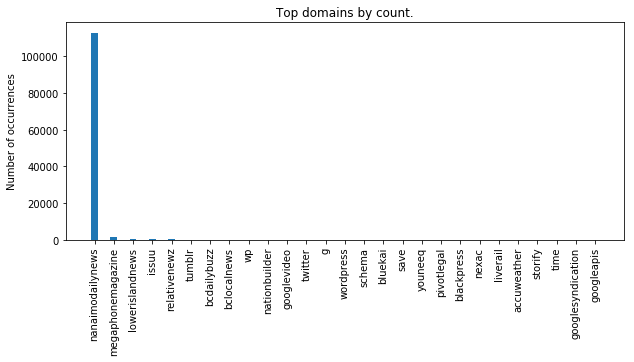

In [47]:
EXCLUDE = ['google', 'facebook', 'youtube', 'apple']
plt.rcParams['figure.figsize'] = [10, 4] # set the figure size for the graph

# Get a list of the top words in the collection
# (regardless of year).

domains = get_domains('name').most_common(30) # Can choose 'sub' for subdomains

vals = [x[1] for x in domains if x[0] not in EXCLUDE]
labs = [x[0] for x in domains if x[0] not in EXCLUDE]

ind = np.arange(len(vals))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, vals, width)

plt.ylabel('Number of occurrences')
plt.title('Top domains by count.')
plt.xticks(ind, labs, rotation='vertical')

plt.show()

As the domain derivative is relatively straightforward, there is not much else that we do with it. 

# Text Analysis

The following set of functions use the [Natural Language Toolkit](https://www.nltk.org) Python library to search for the top most used words in the collection, as well as facilitate breaking it down by name or domain.

### Text by Year

In [ ]:
method = "year" # choose "year", "domain" or "all"

# Get the set of available years in the collection 
year_range = set([x[0] for x in get_text(method)])
print(year_range)

Now we can create separate lists with text files from individual years in this collection. You can add years (e.g. "2019") to `FILTERED_YEARS` in to limit your results.

In [ ]:
year_filter = FILTERED_YEARS if FILTERED_YEARS else year_range # add or remove years for filter
year_results = [t[1] for t in get_text("year") if t[0] in list(year_filter)]
    
# Some of the text may be in an international font.
for i in year_results[:5]:
    print(international(i)[:MAX_CHARACTERS]) # first 50 characters in output

## Removing the # on the following line will write the results to OUTPUT_FILENAME (set in User Configuration).

#write_output(OUTPUT_FILENAME, year_results)

### Text by Domain

In [ ]:
# Get the set of available domains in the collection 
domain_set = set([x[0] for x in get_text("domain")])
print(domain_set)

In [ ]:
# extract only the given domain to a file and see how many results there are

domain_set = FILTERED_DOMAINS if FILTERED_DOMAINS else domain_set
domain_results = [t[1] for t in get_text("domain") if t[0] in domain_set]
print("****Total files****:" + str(len(domain_results)) + "\n")
print("****Sample results****: \n")
for samp in domain_results[:10]:
    if len(samp) > 4:
        print(international(samp)[:MAX_CHARACTERS] + " \n")

## Overall Collection Characteristics

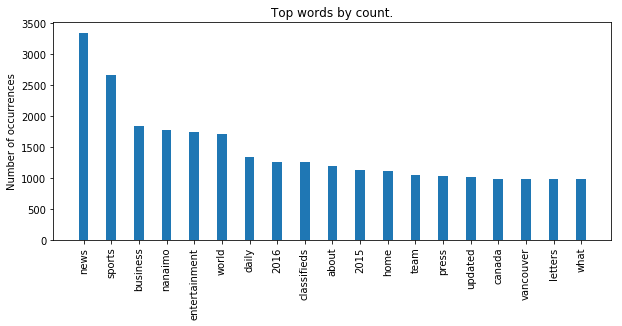

In [26]:
# Get a list of the top words in the collection
# (regardless of year).
tokens = get_top_tokens()[:20]

vals = [x[1] for x in tokens if x[0] not in STOP_WORDS]
labs = [x[0] for x in tokens if x[0] not in STOP_WORDS]

ind = np.arange(len(vals))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, vals, width)

plt.ylabel('Number of occurrences')
plt.title('Top words by count.')
plt.xticks(ind, labs, rotation='vertical')

plt.show()

In [50]:
# Get a list of the top tokens, separated by year.
get_top_tokens_by(year, 3)[0:10]

[('2009', [('News', 12), ('Sports', 10), ('Entertainment', 10)]),
 ('2016', [('News', 3306), ('Sports', 2606), ('Nanaimo', 1776)])]

In [52]:
# Get a list of top tokens, separated by domain.
get_top_tokens_by(domain, 3)[0:10]

[('nanaimodailynews', [('News', 3254), ('Sports', 2616), ('Business', 1758)]),
 ('save', [('Found', 2), ('document', 1), ('moved', 1)]),
 ('schema', [('/div', 104), ('http', 85), ('class=', 85)]),
 ('accuweather', [('AccuWeather.com', 6), ('Radar', 5), ('Weather', 3)]),
 ('issuu', [('publisher', 75), ('Black', 72), ('Press', 72)])]

In [ ]:
# Create a dispersion plot, showing where the list of words appear
# in the text.
text = get_text_tokens(1) # Need to have one to include words with fewer than 3 letters.
dp(text, ["he", "she"]) # uses the nltk dispersion plot library (dp).

In [ ]:
# Collect sentiment scores by domain and visualize them.

sent = sentiment_scores()
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = [x[0] for x in sent]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, neg, width)
p2 = plt.bar(ind, neu, width,
             bottom=neg)
p3 = plt.bar(ind, pos, width, bottom=neu)

plt.ylabel('Scores')
plt.title('Scores by domain and sentiment')
plt.xticks(ind, labs, rotation='vertical')
plt.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

plt.show()


In [ ]:
# Collect sentiment scores by year and visualize them.

sent = sentiment_scores("year")
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = sorted([x[0] for x in sent])

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, neg, width)
p2 = plt.bar(ind, neu, width,
             bottom=neg)
p3 = plt.bar(ind, pos, width, bottom=neu)

plt.ylabel('Scores')
plt.title('Scores by domain and sentiment')
plt.xticks(ind, labs, rotation='vertical')
plt.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

plt.show()

# Network Analysis

Sometimes it is useful to include information about the relationships among different websites. We recommend using [Gephi](https://gephi.org/) for graph visualization, but it is possible in this notebook using the Python networkx library as well.

You may need to adjust the node size, label size and figure size parameters for the layout to look right.

In [ ]:
import networkx as nx

plt.rcParams['figure.figsize'] = [10, 4] # set the figure size for the graph

NETWORK_EXCLUDE = ["google.com"]
graph = nx.read_gexf(auk_gephi) #import the graph

# Degree distribution for the graph

g_nodes = zip([x[1] for x in graph.nodes('label')], [x[1] for x in graph.nodes('Degree')])

gs = sorted([x for x in g_nodes], key=lambda s: s[1], reverse=True)

vals = [x[1] for x in gs if x[0] not in NETWORK_EXCLUDE][:10]
labs = [x[0] for x in gs if x[0] not in NETWORK_EXCLUDE][:10]

ind = np.arange(len(vals))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, vals, width)

plt.ylabel('Degree')
plt.title('Top domains by Degree.')
plt.xticks(ind, labs, rotation='vertical')

plt.show()


In [ ]:
plt.rcParams['figure.figsize'] = [25, 25] # set the figure size for the graph

# Convert rgb values to between 0 & 1 and put them into a numpy array.
rgbs = zip([x[1]/255 for x in graph.nodes('r')], [x[1]/255 for x in graph.nodes('g')], [x[1]/255 for x in graph.nodes('b')])
colormap = [np.array(x) for x in rgbs]

# Labels
mapping = {x[0]: x[1] for x in graph.nodes('label')}

# Use Archive Unleashed Clouds Positions (saves on load time)
zippos = zip(graph.nodes, [x[1] for x in graph.nodes('x')], [x[1] for x in graph.nodes('y')])
positions = {x[0]: np.array([x[1],x[2]]) for x in zippos}

# Node sizes based on degree
size = np.array([x[1] * 100 for x in graph.nodes('size')])

# Draw the graph
nx.draw(graph, pos=positions, show_labels=True, labels=mapping, font_size=10, node_size=size, node_color=colormap)
plt.show()


In [ ]:
# Ego network for a particular node

largest_node = sorted(graph.nodes('Degree'), key=lambda s: s[1], reverse=True)[0][0] # [1][0] is second largest, etc
neigh = graph.subgraph(graph.neighbors(largest_node))
# Convert rgb values to between 0 & 1 and put them into a numpy array.
rgbs = zip([x[1]/255 for x in neigh.nodes('r')], [x[1]/255 for x in neigh.nodes('g')], [x[1]/255 for x in neigh.nodes('b')])
colormap = [np.array(x) for x in rgbs]

# Labels
mapping = {x[0]: x[1] for x in neigh.nodes('label')}

# Use Archive Unleashed Clouds Positions (saves on load time)
zippos = zip(neigh.nodes, [x[1] for x in neigh.nodes('x')], [x[1] for x in neigh.nodes('y')])
positions = {x[0]: np.array([x[1],x[2]]) for x in zippos}

# Node sizes based on degree
size = np.array([x[1] * 100 for x in neigh.nodes('size')])

nx.draw(neigh, pos=positions, show_labels=True, labels=mapping, font_size=10, node_size=size, node_color=colormap)
plt.show()

# Bibliography
- Archives Unleashed Project. (2018). Archives Unleashed Toolkit (Version 0.17.0). Apache License, Version 2.0.
- Bird, Steven, Edward Loper and Ewan Klein (2009), *Natural Language Processing with Python*. O’Reilly Media Inc.
